## Subtypes wm task

In [1]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib

In [2]:
# load good stuff
%matplotlib inline
#%load_ext rpy2.ipython
#%load_ext oct2py.ipython
#sns.set(color_codes=True)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

UsageError: Line magic function `%octave` not found.


In [8]:
#custom function for key sorting element
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [5]:
#  Set path
path_root = '/home/yassinebha/data/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/'
list_subtype_folder = ['subtype_3_spm_WM_18-Oct-2017', 
                       'subtype_4_spm_WM_18-Oct-2017',
                       'subtype_5_spm_WM_18-Oct-2017',
                       'subtype_6_spm_WM_18-Oct-2017',
                       'subtype_7_spm_WM_18-Oct-2017',
                       'subtype_8_spm_WM_18-Oct-2017',
                       'subtype_9_spm_WM_18-Oct-2017',
                       'subtype_10_spm_WM_18-Oct-2017']

In [6]:
# create a mask
mask_file  =  os.path.join(path_root,'templates/mask.nii.gz')
mask_data = nib.load(mask_file).get_data()
mask = mask_data != 0
header_mask = nib.load(mask_file).get_header()
affine_mask = nib.load(mask_file).get_affine()
print('Mask NVoxels = {}'.format(np.sum(mask)))

Mask NVoxels = 76611


In [17]:
for subtype in list_subtype_folder:
    path_subtype = os.path.join(path_root,subtype);
    path_association =  os.path.join(path_subtype,'associations/');
    path_networks =  os.path.join(path_subtype,'networks/');
    nb_sbt = natural_keys(path_subtype)[9]
    # List trials
    list_trial  = [f for f in os.listdir(path_networks)]
    list_subtype = ['sub{}'.format(ii) for ii in range(1,nb_sbt+1)]
    for idx,trial_name in enumerate(list_trial):
        ## Copy spec template
        command = ' '.join(['scp', os.path.join(path_root,'templates/template_spec.spec'),
                            os.path.join(path_networks,trial_name,'{}_spec.spec'.format(trial_name))])
        os.system(command)
        # Load subtypes volume
        file_subtype =glob.glob(os.path.join(path_networks,trial_name)+'/mean_subtype.*')
        file_subtype =''.join(file_subtype)
        tmp = nib.load(file_subtype).get_data()
        tmp = np.swapaxes(np.swapaxes(tmp, 0, 3), 1, 2)

        for subt_id in range(tmp.shape[3]):
            subt_net = tmp[..., subt_id]
            subt_img = nib.Nifti1Image(subt_net, affine=affine_mask,header=header_mask)
            subt_img_file = os.path.join(path_networks,trial_name,'sub{}_mean_subtype.nii.gz'.format(subt_id+1))
            subt_img.to_filename(subt_img_file)

            # volume to surface mapping
            file_in = subt_img_file
            list_templates =['lh','rh','cerebellum']
            for template in list_templates:
                template_file = os.path.join(path_root,'templates/{}.surf.gii'.format(template))
                file_out =  os.path.join(path_networks,trial_name,'sub{}_mean_subtype_{}.surf.gii'.format(subt_id+1,
                                                                                                          template))
                command = ' '.join(['wb_command -volume-to-surface-mapping',
                                    file_in , template_file , file_out ,'-enclosing'])
                os.system(command)
                # Fill spec file
                with open(os.path.join(path_networks,trial_name,'{}_spec.spec'.format(trial_name)),"a") as f:
                    if template == 'cerebellum':
                        print('   <DataFile Structure="Cerebellum"\n\
                 DataFileType="METRIC"\n\
                 Selected="true">\n\
         {}\n\
       </DataFile>'.format(file_out), file=f)
                    elif template == 'rh':
                        print('   <DataFile Structure="CortexRight"\n\
                 DataFileType="METRIC"\n\
                 Selected="true">\n\
         {}\n\
       </DataFile>'.format(file_out), file=f)
                    elif template == 'lh':
                        print('   <DataFile Structure="CortexLeft"\n\
                 DataFileType="METRIC"\n\
                 Selected="true">\n\
         {}\n\
       </DataFile>'.format(file_out), file=f)
                    f.close

        with open(os.path.join(path_networks,trial_name,'{}_spec.spec'.format(trial_name)),"a") as f:
            print('</CaretSpecFile>',file=f)
            f.close

In [9]:
#  Set path
#path_root = '/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/subtype_5_spm_LANGUAGE_03-Oct-2017/';
path_root = '/home/yassinebha/data/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/';
path_subtype = os.path.join(path_root,'subtype_5_spm_WM_18-Oct-2017/');
path_association =  os.path.join(path_subtype,'associations/');
path_networks =  os.path.join(path_subtype,'networks/');
nb_sbt = natural_keys(path_subtype)[9]
nb_sbt

5

In [10]:
# List trials
list_trial  = [f for f in os.listdir(path_networks)]
list_trial 

['contrast_body_vs_other_body',
 'contrast_places_vs_other_places',
 'contrast_2bk_vs_0bk',
 'contrast_tools_vs_other_tools',
 '0bk',
 'contrast_faces_vs_other_faces',
 '2bk']

In [11]:
list_subtype = ['sub{}'.format(ii) for ii in range(1,nb_sbt+1)]
list_subtype

['sub1', 'sub2', 'sub3', 'sub4', 'sub5']

In [12]:
for idx,trial_name in enumerate(list_trial):
    ## Copy spec template
    command = ' '.join(['scp', os.path.join(path_root,'templates/template_spec.spec'),
                        os.path.join(path_networks,trial_name,'{}_spec.spec'.format(trial_name))])
    os.system(command)
    # Load subtypes volume
    file_subtype =glob.glob(os.path.join(path_networks,trial_name)+'/mean_subtype.*')
    file_subtype =''.join(file_subtype)
    tmp = nib.load(file_subtype).get_data()
    tmp = np.swapaxes(np.swapaxes(tmp, 0, 3), 1, 2)
    for subt_id in range(tmp.shape[3]):
        subt_net = tmp[..., subt_id]
        subt_img = nib.Nifti1Image(subt_net, affine=affine_mask,header=header_mask)
        subt_img_file = os.path.join(path_networks,trial_name,'sub{}_mean_subtype.nii.gz'.format(subt_id+1))
        subt_img.to_filename(subt_img_file)
        
        # volume to surface mapping
        file_in = subt_img_file
        list_templates =['lh','rh','cerebellum']
        for template in list_templates:
            template_file = os.path.join(path_root,'templates/{}.surf.gii'.format(template))
            file_out =  os.path.join(path_networks,trial_name,'sub{}_mean_subtype_{}.surf.gii'.format(subt_id+1,
                                                                                                      template))
            command = ' '.join(['wb_command -volume-to-surface-mapping',
                                file_in , template_file , file_out ,'-enclosing'])
            os.system(command)
            # Fill spec file
            with open(os.path.join(path_networks,trial_name,'{}_spec.spec'.format(trial_name)),"a") as f:
                if template == 'cerebellum':
                    print('   <DataFile Structure="Cerebellum"\n\
             DataFileType="METRIC"\n\
             Selected="true">\n\
     {}\n\
   </DataFile>'.format(file_out), file=f)
                elif template == 'rh':
                    print('   <DataFile Structure="CortexRight"\n\
             DataFileType="METRIC"\n\
             Selected="true">\n\
     {}\n\
   </DataFile>'.format(file_out), file=f)
                elif template == 'lh':
                    print('   <DataFile Structure="CortexLeft"\n\
             DataFileType="METRIC"\n\
             Selected="true">\n\
     {}\n\
   </DataFile>'.format(file_out), file=f)
                f.close
                
    with open(os.path.join(path_networks,trial_name,'{}_spec.spec'.format(trial_name)),"a") as f:
        print('</CaretSpecFile>',file=f)
        f.close

In [13]:
os.path.join(path_networks,trial_name,'{}_spec.spec'.format(trial_name))

'/home/yassinebha/data/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/subtype_5_spm_WM_18-Oct-2017/networks/2bk/2bk_spec.spec'

In [13]:
# %%octave -i path_root,path_subtype,path_networks,list_trial
# #split subtype to individual volume
# for nn = 1:size(list_trial)
#     trial_name = list_trial{nn};
#     subtype_folder = [path_networks filesep trial_name ];
#     file_subtype = dir([subtype_folder filesep 'mean_subtype.*']).name;
#     file_in = [subtype_folder filesep file_subtype];
#     [hdr,vol] = niak_read_vol(file_in);
#     for ii  = 1:size(vol)(4)
#         file_n = sprintf('sub%i_mean_subtype.nii.gz',ii);
#         hdr.file_name = [subtype_folder filesep file_n];
#         niak_write_vol(hdr,vol(:,:,:,1));
#         cd ([path_root filesep 'templates/'])
#         system(['sh ' path_root filesep 'templates/volume_to_surface_mapping.sh ' hdr.file_name]);
#     end
# end

In [2]:
from nilearn import surface
from nilearn import plotting

In [3]:
from nilearn import datasets

localizer_dataset = datasets.fetch_localizer_button_task()
localizer_tmap = localizer_dataset.tmaps[0]

In [4]:
fsaverage = datasets.fetch_surf_fsaverage5()

In [5]:
fsaverage

{'description': b"fsaverage5\n\n\nNotes\n-----\nFsaverage5 standard surface as distributed with Freesurfer (Fischl et al, 1999)\n\nContent\n-------\n    :'pial_left': Gifti file, left hemisphere pial surface mesh\n    :'pial_right': Gifti file, right hemisphere pial surface mesh\n    :'infl_left': Gifti file, left hemisphere inflated pial surface mesh\n    :'infl_right': Gifti file, right hemisphere inflated pial\n                   surface mesh\n    :'sulc_left': Gifti file, left hemisphere sulcal depth data\n    :'sulc_right': Gifti file, right hemisphere sulcal depth data\n\nReferences\n----------\nFischl et al, (1999). High-resolution intersubject averaging and a\ncoordinate system for the cortical surface. Hum Brain Mapp 8, 272-284.\n",
 'infl_left': '/home/yassine/nilearn_data/fsaverage5/pial_inflated.left.gii',
 'infl_right': '/home/yassine/nilearn_data/fsaverage5/pial_inflated.right.gii',
 'pial_left': '/home/yassine/nilearn_data/fsaverage5/pial.left.gii',
 'pial_right': '/home

In [31]:
a= '/media/yassine/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/templates/lh.surf.gii'

b= '/media/yassine/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/subtype_5_spm_LANGUAGE_18-Oct-2017/networks/story/sub3_mean_subtype.nii.gz'


In [37]:
texture_l = surface.vol_to_surf(b, fsaverage.pial_left)
texture_r = surface.vol_to_surf(b, fsaverage.pial_right)

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


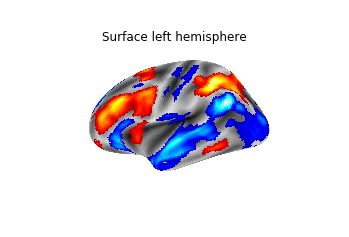

In [64]:
ax = plotting.plot_surf_stat_map(fsaverage.infl_left, texture_l, hemi='left',
                            title='Surface left hemisphere',
                            threshold=0.0002, bg_map=fsaverage.sulc_left,
                            cmap='cold_hot')
ax.savefig('/media/yassine/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/templates/test.png',dpi=700)
ax

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


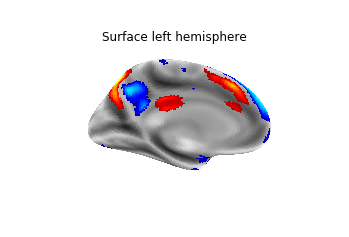

In [83]:
plotting.plot_surf_stat_map(fsaverage.infl_left, texture_l, hemi='left',
                            title='Surface left hemisphere',
                            threshold=0.0002, bg_map=fsaverage.sulc_left,
                            cmap='cold_hot', view ='medial')

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


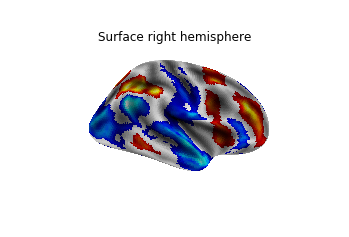

In [82]:
plotting.plot_surf_stat_map(fsaverage.infl_right, texture_r, hemi='right',
                            title='Surface right hemisphere',
                            threshold=0.0002, bg_map=fsaverage.sulc_right,
                            cmap='cold_hot',bg_on_data =True)